In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import ccf
from sklearn.feature_selection import mutual_info_regression

[0.17943283130291743, 0.17835298205642403, 0.17931809653790243, 0.17847577577803975, 0.18003565863140825, 0.18058568659069518, 0.1809328836550277, 0.18017422239254444, 0.18158482223842043, 0.1813222727346977, 0.18170045484098285, 0.18192343322010007, 0.1819681480047981, 0.1819955143473191, 0.1815522776039895, 0.18188069187312106, 0.18244672036211718, 0.18387693627335544, 0.1836560424503899, 0.1828792403775239, 0.18267257148954297, 0.18381333208491135, 0.1828292932886626, 0.18273933042023938, 0.1844980700569323, 0.18331404074650415, 0.1835546914817261, 0.18465701989282035, 0.18379258275279398, 0.18505126590685617, 0.1859901466496625, 0.18628771525256216, 0.18647881123035237, 0.18618860318664154, 0.1867235353874257, 0.18852629595947512, 0.1887264021414019, 0.18883804066948873, 0.18998949163105205, 0.1898833067676371, 0.1914428078057897, 0.19132072882347728, 0.19108590961350025, 0.19141789353737781, 0.19202028538083038, 0.19350997251595725, 0.19431003124535096, 0.19417829707206025, 0.1937

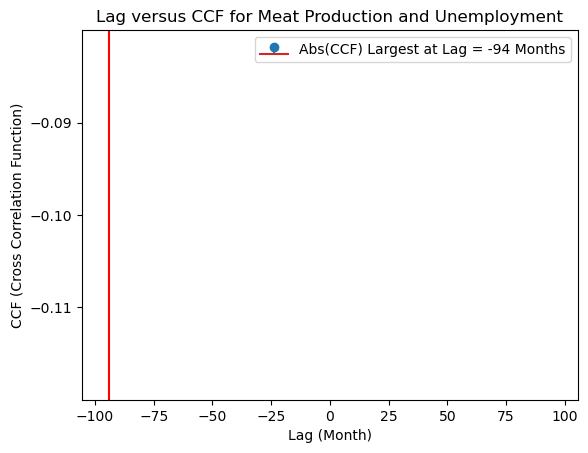

In [12]:
production_df = pd.read_csv('../cleaned-datasets/Cleaned_Meat_Stats_Meat_Production.csv')
economic_df = pd.read_csv('../cleaned-datasets/interpolated_economic_data.csv')
economic_df['Date'] = economic_df['date']

# Averaging data from top meatpacking and poultry processing states into one data point per year
condition_1_states = ["Nebraska", "Iowa", "Texas", "Kansas", "Illinois"]
condition_1 = economic_df["state"].isin(condition_1_states)
condition_2_states = ["Georgia", "Arkansas", "North Carolina", "Alabama", "Mississippi"]
condition_2 = economic_df['state'].isin(condition_2_states)
new_economic_df = economic_df[condition_1 | condition_2].copy()

# Merge datasets on 'Year'
data = pd.merge(production_df, new_economic_df, on='Date')
data.set_index('Date')

# Create an array of lag values
num = 96
lags = np.arange(-num, num + 1)

# aux fn for application
def gen_corr(l1, l2, lag: int) -> float:
    # Positive shift means front becomes NaN, negative shift means end becomes NaN
    if lag < 0:
        shifted_l1 = l1.copy().shift(-lag).dropna() 
        aligned_l2 = l2[:len(shifted_l1)] # align l2 to be the same length as l1
    else:
        shifted_l1 = l1.copy().shift(-lag).dropna() 
        aligned_l2 = l2[lag:]
        aligned_l2 = aligned_l2[:len(shifted_l1)] # Just in case?
        
    return mutual_info_regression(shifted_l1.values.reshape(-1, 1), aligned_l2.values)[0]
    
    # return mutual_info_regression(
    #     l1.shift(lag).dropna().values.reshape(-1, 1), l2.values[:-lag]
    # )
    
# generate correlations
# corr = [gen_corr(data['unemployment_rate'], data['Production'], -lag) for lag in lags if lag <= 0]
# corr += [gen_corr(data['Production'], data['unemployment_rate'], lag) for lag in lags if lag > 0]
corr = [gen_corr(data['unemployment_rate'], data['Production'], lag) for lag in lags]

# # Calculating cross-correlation for negative lags
# neg_ccf = ccf(data['unemployment_rate'], data['Production'])
# neg_ccf = neg_ccf[:num + 1][::-1]

# # Combine with non-negative lags
# pos_ccf = ccf(data['Production'], data['unemployment_rate'])
# all_ccf = list(neg_ccf) + list(pos_ccf[1:num + 1])

all_ccf = corr

print(all_ccf)

max_index = 0
for i in range(0, len(all_ccf)):
    if abs(all_ccf[i]) > abs(all_ccf[max_index]):
        max_index = i
print(max_index - num, all_ccf[max_index])

# Slice the arrays to make the graph less overwhelming
lags_sliced = lags[::4]
ccf_sliced = all_ccf[::4]

plt.stem(lags_sliced, ccf_sliced, label=f'Abs(CCF) Largest at Lag = {min_index - num} Months')
plt.xlabel('Lag (Month)')
plt.ylabel('CCF (Cross Correlation Function)')
plt.axvline(x=min_index - num, color="red")
plt.ylim(-0.12, -0.08)
plt.yticks(np.arange(-0.11, -0.08, 0.01)) # set y-axis ticks at intervals
plt.title('Lag versus CCF for Meat Production and Unemployment')
plt.legend()
plt.savefig('../visualizations/Lag Correlation Coefficients.png')
plt.show()